In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("pkdarabi/the-drug-name-detection-dataset")
print("Path to dataset files:", path)

100%|██████████| 53.5M/53.5M [00:00<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/the-drug-name-detection-dataset/versions/1


In [ ]:
!pip install pytesseract

In [ ]:
import os
import cv2
import pytesseract
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
from tqdm import tqdm

# Set dataset paths
image_dir = os.path.join(path, "images")
csv_path = os.path.join(path, "annotations.csv")

In [ ]:
import os

print("Dataset path:", path)
print("Files and folders:", os.listdir(path))


Dataset path: /root/.cache/kagglehub/datasets/pkdarabi/the-drug-name-detection-dataset/versions/1
Files and folders: ['train', 'valid', 'test', 'data.yaml']


In [ ]:
train_dir = os.path.join(path, 'train')
print(os.listdir(train_dir))

['labels', 'images']


In [ ]:
with open(os.path.join(path, 'data.yaml'), 'r') as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['drug-name']

roboflow:
  workspace: kabul-university-evptq
  project: drug-name-detection
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/kabul-university-evptq/drug-name-detection/dataset/2


In [ ]:
train_images_dir = os.path.join(path, 'train', 'images')
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(image_files[:5])

['triamcinolone_jpg.rf.54ce399e5b440547192f81590e8f3866.jpg', '8LhnQvHLGtUhySKApyUOxyrYpMe_jpg.rf.cf2cc146af81e32cbc0132f33e746fa4.jpg', '8RIeJstDTyFqgCkkEKvXpFTYyzw_jpg.rf.febe15f2753da1bd6bc8479d5878d7aa.jpg', '8T4EeYqTvmXCzGJKVlRUVyDzyry_jpg.rf.997ed74385591395e98aef1030a6bbb5.jpg', 'MTA-38369120_metrix_metrix_full01_jpg.rf.c5e4381272f2103745e06895794c3607.jpg']


In [ ]:
methods = ["simple", "adaptive", "otsu", "none"]

def preprocess_image(img, method="adaptive"):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if method == "simple":
        return cv2.GaussianBlur(gray, (3, 3), 0)
    elif method == "adaptive":
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        return cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    elif method == "otsu":
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, processed = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return processed
    else:
        return gray

results = []
for fname in image_files[:100]:  # limit for demo
    img_path = os.path.join(train_images_dir, fname)
    img = cv2.imread(img_path)
    for method in methods:
        proc = preprocess_image(img, method)
        text = pytesseract.image_to_string(proc)
        results.append({
            "filename": fname,
            "method": method,
            "ocr_text": text,
            "text_len": len(text)
        })


In [ ]:
df = pd.DataFrame(results)
print(df.head())

                                            filename    method  \
0  triamcinolone_jpg.rf.54ce399e5b440547192f81590...    simple   
1  triamcinolone_jpg.rf.54ce399e5b440547192f81590...  adaptive   
2  triamcinolone_jpg.rf.54ce399e5b440547192f81590...      otsu   
3  triamcinolone_jpg.rf.54ce399e5b440547192f81590...      none   
4  8LhnQvHLGtUhySKApyUOxyrYpMe_jpg.rf.cf2cc146af8...    simple   

                                            ocr_text  text_len  
0    \n  \n\nrant 4\n\na9 28\n\nwy veal pes igh t...        81  
1                                                \n         3  
2                                                \n         3  
3                                                \n         3  
4  aan zs\nrevarmyeosuimeg 2 as\n\na mae\n\na\n\n...        54  


In [ ]:
df.to_csv("ocr_preprocessing_results.csv", index=False)

In [ ]:
# For each filename, pick the method with the longest OCR output
best_methods = df.loc[df.groupby('filename')['text_len'].idxmax()]

print(best_methods[['filename', 'method', 'ocr_text', 'text_len']].head())

                                              filename    method  \
331  20230808_181538_jpg.rf.1235c0efa67dea312c57059...      none   
69   20230812_210713_jpg.rf.d6ec5427dc4e68a587de077...  adaptive   
137  20230812_210942_jpg.rf.c2a604e4b3855014de2c432...  adaptive   
341  20230812_213638_jpg.rf.b68927761435ab2510a5cc0...  adaptive   
318  20230812_214134_jpg.rf.7b93806c45b13d26f331f01...      otsu   

                                              ocr_text  text_len  
331   \n  \n\nd\n\nOricox’120\n\nEtoricoxib Tablet ...       100  
69   re\n\n \n\n40 me /~\nSterlite Eye Drops\n\nChi...       373  
137     \n\nan eR\n\nues-ueryay\n\nnoaeg euls\n\n \...       294  
341     \n \n\n15m1,\n\n   \n\n ascorsic aciD\nORAL...        55  
318  MoxiBeena\n\nORT cai\nie ete\nPy dat as Pred I...        83  


In [ ]:
df['num_digits'] = df['ocr_text'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_caps'] = df['ocr_text'].apply(lambda x: sum(c.isupper() for c in x))

In [ ]:
# Mark which rows are the 'best' for each filename
df['is_best'] = 0
best_idx = df.groupby('filename')['text_len'].idxmax()
df.loc[best_idx, 'is_best'] = 1

In [ ]:
feature_cols = ['method', 'text_len', 'num_digits', 'num_caps']
# Encode 'method' as integer
df['method_idx'] = df['method'].map({'simple':0, 'adaptive':1, 'otsu':2, 'none':3})

X = df[['method_idx', 'text_len', 'num_digits', 'num_caps']]
y = df['is_best']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Test accuracy: 0.7


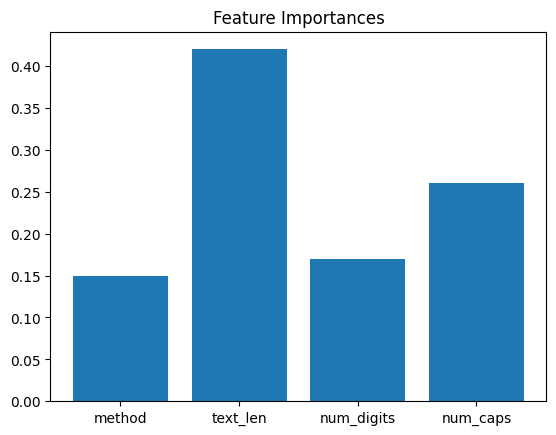

In [ ]:
import matplotlib.pyplot as plt

plt.bar(feature_cols, clf.feature_importances_)
plt.title("Feature Importances")
plt.show()

In [ ]:
import joblib
joblib.dump(clf, "ocr_selector_model.pkl")
print("Model saved as ocr_selector_model.pkl")

Model saved as ocr_selector_model.pkl
